<a id="section-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Notebook resume</div>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Throughout this notebook I will try to develop the complete pipeline for this competition, now it's just a Baseline approach with a very good result in my opinion (Top 15%), rigth now I'm working in the preprocessing and feature engineering steps, which will require a lot of work, in the following weeks I will surely make another update. For the training part, I've took the train class from mi titanic trainer class version 1 kernel <a href="https://www.kaggle.com/maxdiazbattan/titanic-top-5-competition-class-v1-blending">[link]</a>. Any suggestion are welcome. Happy kaggling! </p>

# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> - | Table of contents</div>

* [1-Libraries](#section-one)
* [2-Data loading](#section-two)
* [3-EDA](#section-three)
* [4-Preprocessing and Feature engineering](#section-four)
* [5-Training](#section-five)
* [6-Blending](#section-six)

<a id="section-one"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 1 | Libraries</div>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, impute, preprocessing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn import linear_model, neighbors, naive_bayes, ensemble, svm, neural_network
from category_encoders import TargetEncoder, CatBoostEncoder

In [ ]:
sns.set_style ('darkgrid')

<a id="section-two"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 2 | Data loading</div>

In [ ]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

<a id="section-three"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 3 | EDA</div>

In [ ]:
train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [ ]:
features = [feature for feature in train.columns if feature not in ('Id', 'SalePrice', 'kfold')]

In [ ]:
categorical_features = [feature for feature in train.columns if train[feature].dtype=='O']
numerical_features = [feature for feature in train[features].columns if feature not in categorical_features]

<p style="font-size:25px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
<b>Feature distribution</b></p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Numerical features distribution</p>

In [ ]:
len(numerical_features)

In [ ]:
sns.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(numerical_features):
    plt.subplot(12,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.histplot(data=train, x=train[feature], bins=30,  color='darkblue') 
    g2 = sns.histplot(data=test, x=test[feature], bins=30, color='lightblue')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False);

<div class="alert alert-info" style="border-radius:5px; font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">   
<b> Insights: </b> The distribution of numeric features varies quite a lot, there is some skewed features. Also we can clearly see what features are actually continous and which are categoricals. From the graphs above we can remove the following from the numerical variables:</p>


<ol><b>
    
  <li>'MSSubClass'</li>
  <li>'OverallQual'</li>
  <li>'OverallCond'</li>
  <li>'BsmtHalfBath'</li>
  <li>'BsmtFullBath'</li>
  <li>'FullBath'</li>
  <li>'HalfBath'</li>
  <li>'BedroomAbvGr'</li>
  <li>'KitchenAbvGr'</li>
  <li>'TotRmsAbvGrd'</li>
  <li>'Fireplaces'</li>
  <li>'GarageCars'</li>
  <li>'MoSold'</li>
  <li>'YrSold'</li></b>
</ol> 



In [ ]:
other_categorical_feat = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                          'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','MoSold','YrSold']
new_numerical_features = [feature for feature in numerical_features if feature not in other_categorical_feat]
new_categorical_features = [feature for feature in train[features].columns if feature not in new_numerical_features]

In [ ]:
len(new_numerical_features)

In [ ]:
sns.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(new_numerical_features):
    plt.subplot(8,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.histplot(data=train, x=train[feature], bins=30,  color='darkblue') 
    g2 = sns.histplot(data=test, x=test[feature], bins=30, color='lightblue')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)  
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False);

In [ ]:
sns.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(new_numerical_features):
    plt.subplot(8,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.boxenplot(data=train, x=train[feature],color='darkblue')
    g2 = sns.boxenplot(data=test, x=test[feature], color='lightblue')
    g1.set(xticklabels=[])  
    g1.set(xlabel=None)
    g1.tick_params(bottom=False)    
    g2.set(xticklabels=[])  
    g2.set(xlabel=None)
    g2.tick_params(bottom=False)  

<div class="alert alert-info" style="border-radius:5px; font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">   
<b> Insights: </b> There is a lot of outliers on the data, we need to handle that, this also depend of the model you choose. Also some columns has a lot of NaN values, like 3SsnPorch, PoolArea, MiscVal.</p>


<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Categorical features distribution</p>

In [ ]:
len(new_categorical_features)

In [ ]:
sns.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(new_categorical_features[:29]):
    plt.subplot(10,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.histplot(data=train, x=train[feature], color='darkblue')
    g2 = sns.histplot(data=test, x=test[feature], color='lightblue')
    g1.set(xlabel=None)
    g2.set(xlabel=None)
    plt.xticks(rotation=25)

In [ ]:
sns.set(rc={"figure.figsize":(20, 30)})
for i, feature in enumerate(new_categorical_features[29:]):
    plt.subplot(10,3, i*1 + 1)
    plt.ylabel(feature)
    g1 = sns.histplot(data=train, x=train[feature], color='darkblue')
    g2 = sns.histplot(data=test, x=test[feature], color='lightblue')
    g1.set(xlabel=None)
    g2.set(xlabel=None)

<p style="font-size:25px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
<b>Features cardinality</b></p>

In [ ]:
train_cardinality = (pd.Series({feature: len(train[feature].unique()) for feature in train[categorical_features]})
                     .reset_index().rename(columns={'index':'Feature',0:'Cardinality'}))

In [ ]:
sns.set(rc={"figure.figsize":(10, 12)})
g=sns.barplot(data=train_cardinality.sort_values(by='Cardinality',ascending=False), 
              x = 'Cardinality', 
              y = 'Feature', 
              palette = 'rainbow');

In [ ]:
test_cardinality = (pd.Series({feature: len(test[feature].unique()) for feature in test[categorical_features]}).reset_index()
                     .rename(columns={'index':'Feature', 0:'Cardinality'}))

In [ ]:
g=sns.barplot(data=test_cardinality.sort_values(by='Cardinality', ascending=False), 
              x = 'Cardinality', 
              y = 'Feature', 
              palette = 'rainbow');

In [ ]:
(pd.merge(train_cardinality,test_cardinality, on='Feature', how='left')
 .sort_values(by=['Cardinality_x', 'Cardinality_y'], ascending=[False,False])
 .rename(columns={'Cardinality_x':'Train Cardinality','Cardinality_y':'Test Cardinality'}))

<div class="alert alert-info" style="border-radius:5px; font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">   
<b> Insights: </b> Here we can see that the cardinality is not the same in the 2 datasets, it varies in some features, especially in Condition2 and RoofMatl. Also it's quite high in some of the features, for this reason in my opinion a manual encoding is the proper way to handle this.</p>

<p style="font-size:25px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
<b>Missing Values</b></p>


In [ ]:
missing_vals = (pd.Series(train.isna().sum()).reset_index().rename(columns={'index': 'Feature', 0: 'Missing Values'}))

In [ ]:
sns.set(rc={"figure.figsize":(10, 12)})
g=sns.barplot(data=missing_vals[missing_vals['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False), 
              x = 'Missing Values', 
              y = 'Feature', 
              palette = 'rainbow');

<div class="alert alert-info" style="border-radius:5px; font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">   
<b> Insights: </b> There are a large number of missing values that there are in some features, but that does not mean that this missing value does not represent anything, but rather that it may be poorly encoded. For example, the first feature with missing values is PoolQC and the missing values are due to the fact that many houses do not have a pool (NA=No Pool). Therefore, if we drop the column, we're losing valuable information about whether a house has a pool or not, which will possibly have an impact on the SalePrice. This is going to require manual handling of missing values, and leaving out sklearn's imputation.</p>


<p style="font-size:25px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
<b>Features relationships with the target value</b></p>


<p style="font-size:20px; font-family:verdana; line-height: 1.7em;margin-left:20px">   
Numerical</p>

In [ ]:
sns.set(rc={"figure.figsize":(22, 30)})
for i, feature in enumerate(new_numerical_features):
    plt.subplot(8,3, i*1 + 1)
    g1 = sns.scatterplot(data=train,
                         x = train[feature], 
                         y = np.log(train['SalePrice']), 
                         hue =  np.log(train['SalePrice']), 
                         palette = 'rainbow')

<div class="alert alert-info" style="border-radius:5px; font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">   
<b> Insights: </b> We can see that there are several features with a direct relationship in the SalePrice such as Basement, Floors, Ground Area, Garage.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Categorical</p>

In [ ]:
sns.set(rc={"figure.figsize":(22, 34)})
for i, feature in enumerate(new_categorical_features[:29]):
    plt.subplot(10,3, i*1 + 1)
    g1 = sns.violinplot(data=train, x=train[feature], y=np.log(train['SalePrice']) ,palette='rainbow')
    g1.set(xlabel=None)
    plt.xticks(rotation=20)
    plt.title(feature, x=0.9, y=0.9)

In [ ]:
for i, feature in enumerate(new_categorical_features[29:]):
    plt.subplot(10,3, i*1 + 1)
    g1 = sns.violinplot(data=train, x=train[feature], y=np.log(train['SalePrice']) ,palette='rainbow') 
    g1.set(xlabel=None)
    plt.xticks(rotation=25)
    plt.title(feature, x=0.9, y=0.9)

<div class="alert alert-info" style="border-radius:5px; font-size:15px; font-family:verdana; line-height: 1.7em; margin-left:20px">
<p style="font-size:18px; font-family:verdana; line-height: 1.7em">   
<b> Insights: </b> Here also we can see that there are several features with a direct relationship in the SalePrice such as Overal quality, Total rooms.</p>

<a id="section-four"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 4 | Preprocessing and Feature engineering</div>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
This process is going to require a lot of work if the idea is to improve the baseline score of 0.12590, so for this I have to keep working, since most of the preprocessing will be done manually. In the coming weeks I will upload updates to complete this section.</p>

In [ ]:
# Creation of a fake target value (-1) for concatenation purposes
test['SalePrice'] = -1
combined_df = pd.concat([train,test], axis = 0)

In [ ]:
def preprocessing_inputs(df):
    df = df.copy()
    
     # Filling NA categoric features
    na_features = ['Alley', 'MasVnrType', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                   'FireplaceQu','GarageType', 'GarageFinish','GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
 
    df['MasVnrType'].replace({'None': np.NaN}, inplace=True)
    for feature in na_features:
        df[feature] = df[feature].fillna('No')
    
    na_test_features = ['MSZoning', 'Utilities', 'Exterior1st','Exterior2nd','KitchenQual', 'Functional', 'SaleType' ]
    for feature in na_test_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    
    # Split the dataframe
    train = df.query("SalePrice != -1").copy()
    
    test = df.query("SalePrice == -1").copy()
    test.drop(['SalePrice'], axis = 1, inplace=True)
    
    return train, test

In [ ]:
train_, test_ = preprocessing_inputs(combined_df)

<a id="section-five"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 5 | Training </div>

In [ ]:
class ModelTrain():
    
    """
    Trainer class which is responsible for imputing, encoding, scaling and training the models.
    Args:
        - train: Train dataframe.
        - test: Test dataframe.
        - sub: Submission dataframe.
        - n_splits: Number of folds.
        - num_feats: Numerical features (list).
        - cat_feats: Categorical features (list).
        - model_name: The corresponding model name to be used to identify it in the training process.
        - model: Model to train.
        - preprocessing: Preprocessing process (boolean).
        - impute_type: Impute type for missing values.
        - encode_type: Encoding type for categorical features.
        - scale_type: Scale or transforming.
    """
    
    def __init__(self, train, test, sub, n_splits, features, num_feats, cat_feats, target, model_name, model,
                 preprocessing=False, impute_type=False, encode_type=False, scale_type=False ):
    
        self.train = train
        self.test = test
        self.sub = sub
        self.n_splits = n_splits
        self.num_feats = num_feats
        self.cat_feats = cat_feats
        self.target = target
        self.model_name = model_name
        self.model = model
        self.preprocessing = preprocessing
        self.impute_type = impute_type
        self.encode_type = encode_type
        self.scale_type = scale_type
        
        self.valid_preds = {}
        self.test_preds = []
    
    def kfold(self):
        
        """
        Folds creation.
        """
        
        n_splits = self.n_splits
        target = self.target
        df = self.train.copy()
        df['kfold'] = -1
        
        skf= model_selection.KFold (n_splits=n_splits, shuffle=True, random_state=0)
        for fold, (train_idx, valid_idx) in enumerate (skf.split(X=df)):
            df.loc[valid_idx,'kfold'] = fold
        return df
    
    def imputer_(self, xtrain, xvalid, xtest):
        
        """
        Impute the missing values.
        Args:
            - xtrain: Train dataframe.
            - xvalid: Validation dataframe.
            - xtest: Test dataframe.
        """
        
        self.xtrain = xtrain
        self.xvalid = xvalid
        self.xtest = xtest
        
        num_feats = self.num_feats
        cat_feats = self.cat_feats
        
        if self.impute_type == 'SI':
            
            si_n = impute.SimpleImputer(strategy='mean')
            self.xtrain[num_feats] = si_n.fit_transform(self.xtrain[num_feats])
            self.xvalid[num_feats] = si_n.transform(self.xvalid[num_feats])
            self.xtest[num_feats] = si_n.transform(self.xtest[num_feats])
            
            si_c = impute.SimpleImputer(strategy='most_frequent')
            self.xtrain[cat_feats] = si_c.fit_transform(self.xtrain[cat_feats])
            self.xvalid[cat_feats] = si_c.transform(self.xvalid[cat_feats])
            self.xtest[cat_feats] = si_c.transform(self.xtest[cat_feats])
            
            self.xtrain = self.xtrain[num_feats+cat_feats]
            self.xvalid = self.xvalid[num_feats+cat_feats]
            self.xtest = self.xtest[num_feats+cat_feats]
            
            return self.xtrain, self.xvalid, self.xtest
        
        else:
            raise Exception ('Impute type not supported, supported types SI.')
    
    def scaler_transformer_(self, xtrain, xvalid, xtest):
        
        """
        Scale/transform the numerical values.
        Args:
            - xtrain: Train dataframe.
            - xvalid: Validation dataframe.
            - xtest: Test dataframe.
        """
        
        self.xtrain = xtrain
        self.xvalid = xvalid
        self.xtest = xtest
        num_feats = self.num_feats
        
        if self.scale_type == 'STD':
            std = preprocessing.StandardScaler()
            self.xtrain[num_feats] = std.fit_transform(self.xtrain[num_feats])
            self.xvalid[num_feats] = std.transform(self.xvalid[num_feats])
            self.xtest[num_feats] = std.transform(self.xtest[num_feats])
            return self.xtrain[num_feats], self.xvalid[num_feats], self.xtest[num_feats]
        
        elif self.scale_type == 'MINMAX':
            mm = preprocessing.MinMaxScaler()
            self.xtrain[num_feats] = mm.fit_transform(self.xtrain[num_feats])
            self.xvalid[num_feats] = mm.transform(self.xvalid[num_feats])
            self.xtest[num_feats] = mm.transform(self.xtest[num_feats])
            return self.xtrain[num_feats], self.xvalid[num_feats], self.xtest[num_feats]
        
        elif self.scale_type == 'MAXABS':
            mabs = preprocessing.MaxAbsScaler()
            self.xtrain[num_feats] = mabs.fit_transform(self.xtrain[num_feats])
            self.xvalid[num_feats] = mabs.transform(self.xvalid[num_feats])
            self.xtest[num_feats] = mabs.transform(self.xtest[num_feats])
            return self.xtrain[num_feats], self.xvalid[num_feats], self.xtest[num_feats]
        
        elif self.scale_type == 'RBT':
            rbt = preprocessing.RobustScaler()
            self.xtrain[num_feats] = rbt.fit_transform(self.xtrain[num_feats])
            self.xvalid[num_feats] = rbt.transform(self.xvalid[num_feats])
            self.xtest[num_feats] = rbt.transform(self.xtest[num_feats])
            return self.xtrain[num_feats], self.xvalid[num_feats], self.xtest[num_feats]
        
        elif self.scale_type == 'PWR':
            pwr = preprocessing.PowerTransformer(method='yeo-johnson')
            self.xtrain[num_feats] = pwr.fit_transform(self.xtrain[num_feats])
            self.xvalid[num_feats] = pwr.transform(self.xvalid[num_feats])
            self.xtest[num_feats] = pwr.transform(self.xtest[num_feats])
            return self.xtrain[num_feats], self.xvalid[num_feats], self.xtest[num_feats]
        
        elif self.scale_type == 'FNC':
            fnc = preprocessing.FunctionTransformer(np.log1p, validate = True)
            mm = preprocessing.MinMaxScaler()
            
            self.xtrain[num_feats] = fnc.fit_transform(mm.fit_transform(self.xtrain[num_feats]))
            self.xvalid[num_feats] = fnc.transform(mm.transform(self.xvalid[num_feats]))
            self.xtest[num_feats] = fnc.transform(mm.transform(self.xtest[num_feats]))
            return self.xtrain[num_feats], self.xvalid[num_feats], self.xtest[num_feats]
            
        else:
            raise Exception ('Scaler/Transformer type not supported, supported types STD, MINMAX, MAXABS, RBT, PWR, FNC(Log).')
    
    def encoder_(self, xtrain, xvalid, xtest):
        
        """
        Encode categorical values.
        Args:
            - xtrain: Train dataframe.
            - xvalid: Validation dataframe.
            - xtest: Test dataframe.
        """

        self.xtrain = xtrain
        self.xvalid = xvalid
        self.xtest = xtest
        cat_feats = self.cat_feats
        
        if self.encode_type == 'OHE':
            ohe = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')
            ohe.fit(self.xtrain[cat_feats].fillna('-9999').values)
            encoded_cols = list(ohe.get_feature_names(cat_feats))
            self.xtrain[encoded_cols] = ohe.fit_transform(self.xtrain[cat_feats].fillna('-9999'))
            self.xvalid[encoded_cols] = ohe.transform(self.xvalid[cat_feats].fillna('-9999'))
            self.xtest[encoded_cols] = ohe.transform(self.xtest[cat_feats].fillna('-9999'))
            return self.xtrain, self.xvalid, self.xtest, encoded_cols
                
        elif self.encode_type == 'ORD':
            # Works with sklearn v 0.24 by setting the handle_unknown parameter
            ord_ = preprocessing.OrdinalEncoder()
            encoded_cols = list(self.train[cat_feats].columns)
            self.xtrain[encoded_cols] = ord_.fit_transform(self.xtrain[cat_feats].fillna('-9999'))
            self.xvalid[encoded_cols] = ord_.transform(self.xvalid[cat_feats].fillna('-9999'))
            self.xtest[encoded_cols] = ord_.transform(self.xtest[cat_feats].fillna('-9999'))
            return self.xtrain, self.xvalid, self.xtest, encoded_cols
        
        elif self.encode_type == 'LBL':
            lbl_ = preprocessing.LabelEncoder()
            encoded_cols = list(self.train[cat_feats].columns)
            for c in encoded_cols:
                self.xtrain.loc[:, c] = lbl_.fit_transform(self.xtrain[c].fillna('-9999'))
                self.xvalid.loc[:, c] = lbl_.transform(self.xvalid[c].fillna('-9999'))
                self.xtest.loc[:, c] = lbl_.transform(self.xtest[c].fillna('-9999'))
            return self.xtrain, self.xvalid, self.xtest, encoded_cols
        
        else:
            raise Exception ('Encoded type not supported, supported types OHE, LBL, or ORD.')
    
    def train_test (self):     
        
        self.train_df = self.kfold().copy()
        scores = []
               
        for fold in range(self.n_splits):
            
            X_train = self.train_df[self.train_df.kfold != fold].reset_index(drop=True)
            X_valid = self.train_df[self.train_df.kfold == fold].reset_index(drop=True)

            X_test = self.test[self.num_feats+self.cat_feats].copy() #

            X_valid_ids = X_valid.Id.values.tolist()

            y_train = X_train[self.target]
            y_valid = X_valid[self.target]

            X_train = X_train[self.num_feats+self.cat_feats]
            X_valid = X_valid[self.num_feats+self.cat_feats]
            
            # Preprocessing
            if self.preprocessing:
                if self.impute_type == False or self.scale_type == False:
                    xtrain, xvalid, xtest = X_train, X_valid, X_test    
                if self.impute_type != False:
                    xtrain, xvalid, xtest = self.imputer_(X_train, X_valid, X_test)
                if self.scale_type != False:
                    xtrain, xvalid, xtest = self.scaler_transformer_(xtrain, xvalid, xtest)
                if self.encode_type != False:
                    xtrain_e, xvalid_e, xtest_e, cols = self.encoder_(X_train, X_valid, X_test)           
                else:
                    xtrain_e, xvalid_e, xtest_e, cols = X_train, X_valid, X_test, categoric_features             
       
                X_train = pd.concat([xtrain[self.num_feats], xtrain_e[cols]], axis=1)
                X_valid = pd.concat([xvalid[self.num_feats], xvalid_e[cols]], axis=1)
                X_test = pd.concat([xtest[self.num_feats], xtest_e[cols]], axis=1)
                
            # Training & Predicting
            model.fit(X_train, y_train) 

            preds_valid = model.predict(X_valid)
            preds_test = model.predict(X_test)
            
            self.valid_preds.update(dict(zip(X_valid_ids,preds_valid )))
            self.test_preds.append(preds_test)

            rmse = metrics.mean_squared_error(y_valid , preds_valid, squared=False)
            scores.append(rmse)
            
            print(f'Fold = {fold}, RMSE = {rmse:.10f}')    
        print(f'Mean score {self.model_name} = {np.mean(scores):.10f}')
        print()
        
        valid_df = pd.DataFrame.from_dict(self.valid_preds, orient='index').reset_index().rename(columns = {'index':'Id', 0:f'preds_{self.model_name}'})
        
        test_df = self.sub.copy()
        test_df.drop(self.target, axis=1, inplace=True)
        test_df.loc[:,f'preds_{self.model_name}'] = np.mean(np.column_stack (self.test_preds), axis=1 ).astype(int)
        
        return valid_df , test_df, self.train_df

In [ ]:
models = {
          'XGB': xgb.XGBRegressor(random_state = 0),
          'LGBM': lgb.LGBMRegressor(random_state = 0),
          'CB': cb.CatBoostRegressor(random_state = 0, verbose=False),
          'KNN': neighbors.KNeighborsRegressor(),
          'RF': ensemble.RandomForestRegressor(random_state=0),
          'RI': linear_model.Ridge(random_state=0),
          'BR': linear_model.BayesianRidge(),
          'LA': linear_model.Lasso(random_state=0),
}

In [ ]:
dfs_valid = []
dfs_test = []
for name, model in models.items():
    house = ModelTrain(train_, test_, submission, 5, features , numerical_features, categorical_features, 'SalePrice', 
                       name, model, preprocessing=True, impute_type='SI', scale_type='RBT', encode_type='OHE' )
    df_valid, df_test, train_df = house.train_test()

    dfs_valid.append(df_valid)
    dfs_test.append(df_test)

In [ ]:
final_valid_df = pd.concat(dfs_valid, axis=1)
final_test_df = pd.concat(dfs_test, axis=1)

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Choosing the best models to do the final blend</p>

In [ ]:
df_valid = final_valid_df.iloc[:,[0,1,3,5,9,11,15]]
df_test = final_test_df.iloc[:,[0,1,3,5,9,11,15]]

In [ ]:
df_valid.sample(5)

In [ ]:
train_blend = pd.merge(train_df, df_valid, on='Id', how='left')
test_blend = pd.merge(test, df_test, on='Id' , how='left')

In [ ]:
feat =  ['preds_XGB','preds_LGBM','preds_CB', 'preds_RF','preds_RI','preds_LA']

<a id="section-six"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#000000;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 6 | Blending</div>

<p style="font-size:25px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
<b>Approach 1: Find the best weights with LinearRegression</b></p>

In [ ]:
# Meta Model LR

train = train_blend.copy()
test = test_blend.copy()

scores = []
valid_preds_lr = {}
test_preds_lr = []

for fold in range(5):
    
    X_train = train[train.kfold != fold].reset_index(drop=True)
    X_valid = train[train.kfold == fold].reset_index(drop=True)
    
    X_test = test[feat].copy() #
    
    X_valid_ids = X_valid.Id.values.tolist()

    y_train = X_train['SalePrice']
    y_valid = X_valid['SalePrice']
    
    X_train = X_train[feat]
    X_valid = X_valid[feat]
    
    # Model
    model = linear_model.LinearRegression()
    
    model.fit(X_train, y_train) 
        
    preds_valid = model.predict(X_valid)
    preds_test = model.predict(X_test)
    
    valid_preds_lr.update(dict(zip(X_valid_ids,preds_valid )))
    test_preds_lr.append(preds_test)
    
    rmse = metrics.mean_squared_error(y_valid, preds_valid, squared=False)
    scores.append(rmse)
    
    print(f' Fold = {fold}, RMSE = {rmse:.10f}')
print(f'Mean score = {np.mean(scores):.10f} Std = {np.std(scores):.3f} ')

In [ ]:
level1_valid_preds_lr = pd.DataFrame.from_dict(valid_preds_lr, orient='index').reset_index().rename(columns = {'index':'Id', 0:'lr_pred_1'})

level1_test_preds_lr = submission.copy()
level1_test_preds_lr.SalePrice = np.mean(np.column_stack (test_preds_lr), axis=1 ).astype(int)
level1_test_preds_lr.to_csv('lr-submission.csv', index = False)

In [ ]:
level1_test_preds_lr.sample(5)

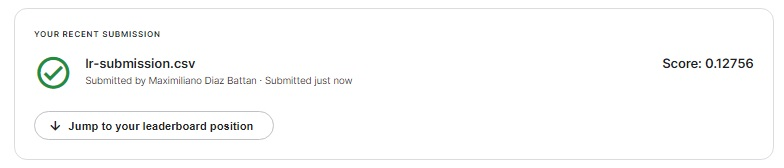

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Linear Regression gives me a higher score compared to weighted averaging</p>

<p style="font-size:25px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
<b>Approach 2: Weighted average of the predictions</b></p> 

In [ ]:
pred1 = df_test.preds_XGB
pred2 = df_test.preds_LGBM
pred3 = df_test.preds_CB
pred4 = df_test.preds_RF
pred5 = df_test.preds_RI

In [ ]:
wavg_preds = (pred1+pred2+pred3+pred4+pred5) / 5

In [ ]:
submission.SalePrice = wavg_preds

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.sample(5)

<p style="font-size:20px; font-family:verdana; line-height: 1.7em; margin-left:20px">   
Weighted average baseline</p>

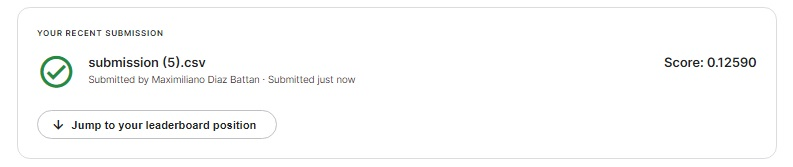